# Silver Analytics - Uber & Ola Ride Booking & Cancellation Data

---

Etapa para a análise com insights dos dados já limpos e tratados. Será mantido a mesma estrutura de código da raw.

* Validação e Integridade
* Data Profiling e Categorização
* Avaliação de Qualidade dos Dados
* Identificação de Visualização de Outliers
* Detecção de Anomalias

# 1. Bibliotecas

In [8]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import StringType

import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

# 2. Carregamento dos Dados e Visualização Inicial

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("silver") \
    .config(
        "spark.jars.packages",
        "org.postgresql:postgresql:42.7.3"
    ) \
    .getOrCreate()


jdbc_url = "jdbc:postgresql://localhost:5432/cars_trips"

properties = {
    "user": "postgres",
    "password": "postgres",
    "driver": "org.postgresql.Driver"
}

df_silver = spark.read.jdbc(
    url=jdbc_url,
    table="silver.road_trips",
    properties=properties
)

df_silver.show()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
26/01/19 09:31:41 WARN Utils: Your hostname, CyberCore, resolves to a loopback address: 127.0.1.1; using 172.29.111.35 instead (on interface wlp0s20f3)
26/01/19 09:31:41 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
:: loading settings :: url = jar:file:/home/daniel-barros/Documentos/Faculdade/Sistemas%20de%20Banco%20de%20Dados%202%20-%20Thiago%20Luiz/car_rides_analytics/venv/lib/python3.12/site-packages/pyspark/jars/ivy-2.5.3.jar!/org/apache/ivy/core/settings/ivysettings.xml
Ivy Default Cache set to: /home/daniel-barros/.ivy2.5.2/cache
The jars for the packages stored in: /home/daniel-barros/.ivy2.5.2/jars
org.postgresql#postgresql added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-7b0bdcd1-b6c3-4cdb-831d-76d8404da306;1.0
	confs: [default]
	found org.postgresql#postgresql;42.7.3 in central
	found org.checkerframework#checker-qual;3.42.0 in centr

+---+----------+-------------------+--------------------+-----------+------------+-----------------+-------------+------------------+-----------------------+--------------------+--------------------+----------------+-----------------------+-------------+--------------+-------------+--------------+---------------+
| id|      date|               time|      booking_status|customer_id|vehicle_type|  pickup_location|drop_location|driver_time_accept|passenger_time_boarding|canceled_by_customer|  canceled_by_driver|incomplete_rides|incomplete_rides_reason|booking_value|payment_method|ride_distance|driver_ratings|customer_rating|
+---+----------+-------------------+--------------------+-----------+------------+-----------------+-------------+------------------+-----------------------+--------------------+--------------------+----------------+-----------------------+-------------+--------------+-------------+--------------+---------------+
|  1|2024-07-26|1970-01-01 14:00:00|  Canceled by Drive

# 3. Validação e Integridade

Estrutura com os tipos corretos agora.

In [3]:
print(f"\n{'='*10} COLUNAS E SUAS INFORMAÇÕES ESTTUTURAIS {'='*10}\n")
df_silver.printSchema()


========== COLUNAS E SUAS INFORMAÇÕES ESTTUTURAIS ==========

root
 |-- id: long (nullable = true)
 |-- date: date (nullable = true)
 |-- time: timestamp (nullable = true)
 |-- booking_status: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- vehicle_type: string (nullable = true)
 |-- pickup_location: string (nullable = true)
 |-- drop_location: string (nullable = true)
 |-- driver_time_accept: integer (nullable = true)
 |-- passenger_time_boarding: integer (nullable = true)
 |-- canceled_by_customer: string (nullable = true)
 |-- canceled_by_driver: string (nullable = true)
 |-- incomplete_rides: boolean (nullable = true)
 |-- incomplete_rides_reason: string (nullable = true)
 |-- booking_value: decimal(10,2) (nullable = true)
 |-- payment_method: string (nullable = true)
 |-- ride_distance: integer (nullable = true)
 |-- driver_ratings: decimal(3,2) (nullable = true)
 |-- customer_rating: decimal(3,2) (nullable = true)



In [4]:
print(f"\n{'='*10} ESTATÍSTICAS BÁSICAS DAS COLUNAS {'='*10}\n")

df_silver.summary().show()


========== ESTATÍSTICAS BÁSICAS DAS COLUNAS ==========



26/01/19 09:31:51 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-----------------+--------------------+-----------+------------+---------------+-------------+------------------+-----------------------+--------------------+--------------------+-----------------------+---------------+--------------+------------------+------------------+------------------+
|summary|               id|      booking_status|customer_id|vehicle_type|pickup_location|drop_location|driver_time_accept|passenger_time_boarding|canceled_by_customer|  canceled_by_driver|incomplete_rides_reason|  booking_value|payment_method|     ride_distance|    driver_ratings|   customer_rating|
+-------+-----------------+--------------------+-----------+------------+---------------+-------------+------------------+-----------------------+--------------------+--------------------+-----------------------+---------------+--------------+------------------+------------------+------------------+
|  count|            92900|               92900|      92900|       92900|          92900|        

## 3.1 Colunas com Dados Faltantes

Visualização da nova quantidade de colunas com dados faltantes.

In [9]:
total_rows = df_silver.count()
missing_data = []

for field in df_silver.schema.fields:
    column = field.name
    dtype = field.dataType

    # NULL vale para qualquer tipo
    nulos = df_silver.filter(F.col(column).isNull()).count()

    # String vazia só faz sentido para StringType
    if isinstance(dtype, StringType):
        vazios = df_silver.filter(F.col(column) == '').count()
    else:
        vazios = 0

    total = nulos + vazios
    percentual = round((total / total_rows) * 100, 2)

    missing_data.append({
        'Coluna': column,
        'Nulos': nulos,
        'Vazios': vazios,
        'Total': total,
        '%': percentual
    })

df_missing = spark.createDataFrame(missing_data) \
    .orderBy(F.col('Total').asc())

df_missing.show(truncate=False)

+-----+-----------------------+-----+-----+------+
|%    |Coluna                 |Nulos|Total|Vazios|
+-----+-----------------------+-----+-----+------+
|0.0  |customer_id            |0    |0    |0     |
|0.0  |booking_value          |0    |0    |0     |
|0.0  |time                   |0    |0    |0     |
|0.0  |pickup_location        |0    |0    |0     |
|0.0  |booking_status         |0    |0    |0     |
|0.0  |id                     |0    |0    |0     |
|0.0  |drop_location          |0    |0    |0     |
|0.0  |ride_distance          |0    |0    |0     |
|0.0  |date                   |0    |0    |0     |
|0.0  |vehicle_type           |0    |0    |0     |
|31.14|payment_method         |28933|28933|0     |
|31.14|incomplete_rides       |28933|28933|0     |
|31.14|driver_time_accept     |28933|28933|0     |
|31.14|driver_ratings         |28933|28933|0     |
|31.14|passenger_time_boarding|28933|28933|0     |
|31.14|customer_rating        |28933|28933|0     |
|80.16|canceled_by_driver     |

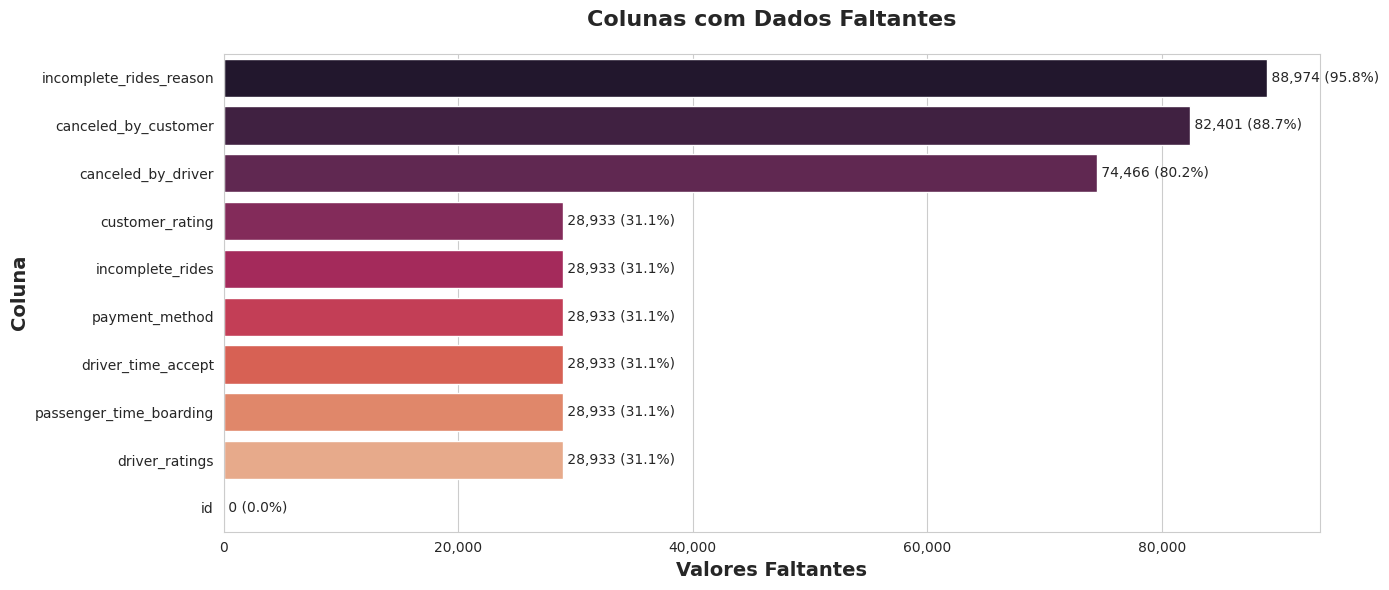

In [10]:
missing_data = df_missing.toPandas()
missing_data = missing_data.sort_values('Total', ascending=False)
top_missing = missing_data.head(10).reset_index(drop=True)

sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(14, 6))
sns.barplot(data=top_missing, y='Coluna', x='Total', hue='Coluna', ax=ax, palette='rocket', legend=False)

ax.set_xlabel('Valores Faltantes', fontsize=14, fontweight='bold')
ax.set_ylabel('Coluna', fontsize=14, fontweight='bold')
ax.set_title('Colunas com Dados Faltantes', fontsize=16, fontweight='bold', pad=20)

for i in range(len(top_missing)):
    row = top_missing.iloc[i]
    ax.text(row['Total'], i, f" {row['Total']:,.0f} ({row['%']:.1f}%)", 
            ha='left', va='center', fontsize=10)

ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))

plt.tight_layout()
plt.show()

# 4. Data Profiling e Categorização

Nova analise sem a parte de corridas que não foram iniciadas.

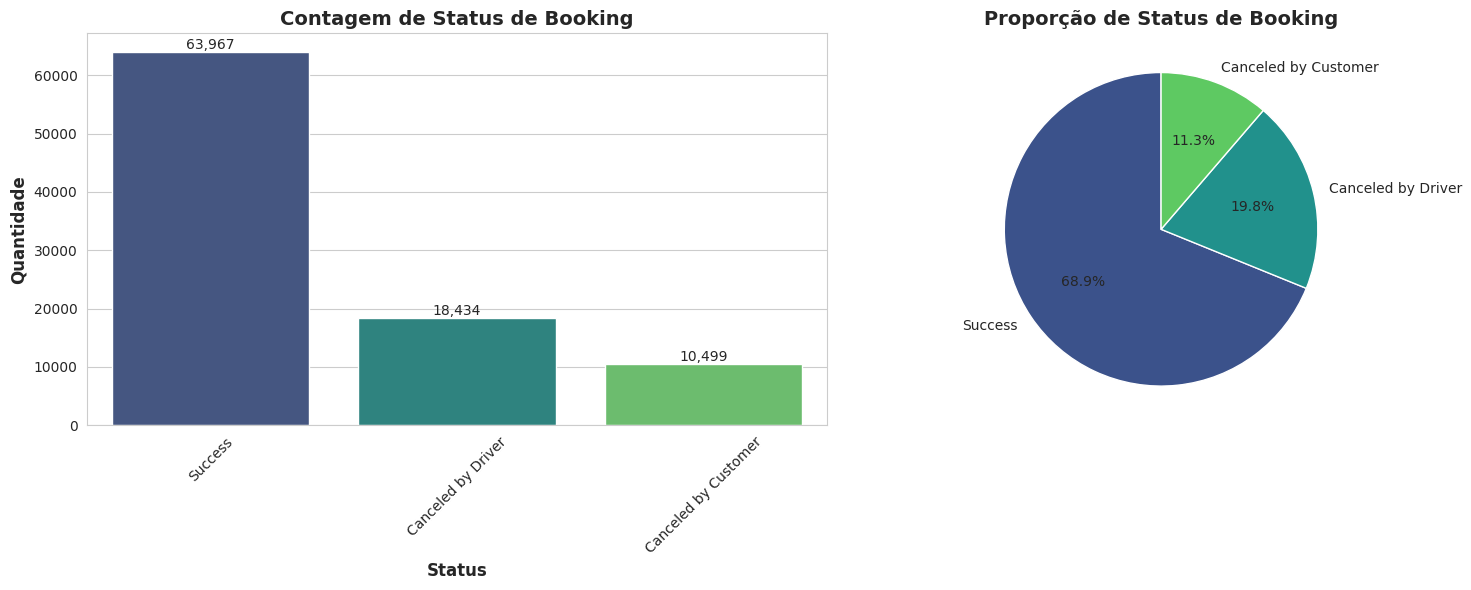

In [11]:
booking_status = df_silver.groupBy("Booking_Status").count().toPandas()
booking_status = booking_status.sort_values('count', ascending=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico de barras
sns.barplot(data=booking_status, x='Booking_Status', y='count', hue='Booking_Status', ax=ax1, palette='viridis', legend=False)
ax1.set_title('Contagem de Status de Booking', fontsize=14, fontweight='bold')
ax1.set_xlabel('Status', fontsize=12, fontweight='bold')
ax1.set_ylabel('Quantidade', fontsize=12, fontweight='bold')
ax1.tick_params(axis='x', rotation=45)

for i, v in enumerate(booking_status['count']):
    ax1.text(i, v, f'{v:,}', ha='center', va='bottom')

# Gráfico de pizza
colors = sns.color_palette('viridis', len(booking_status))
ax2.pie(booking_status['count'], labels=booking_status['Booking_Status'], autopct='%1.1f%%', colors=colors, startangle=90)
ax2.set_title('Proporção de Status de Booking', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

Nova variação e distribuição de veículos

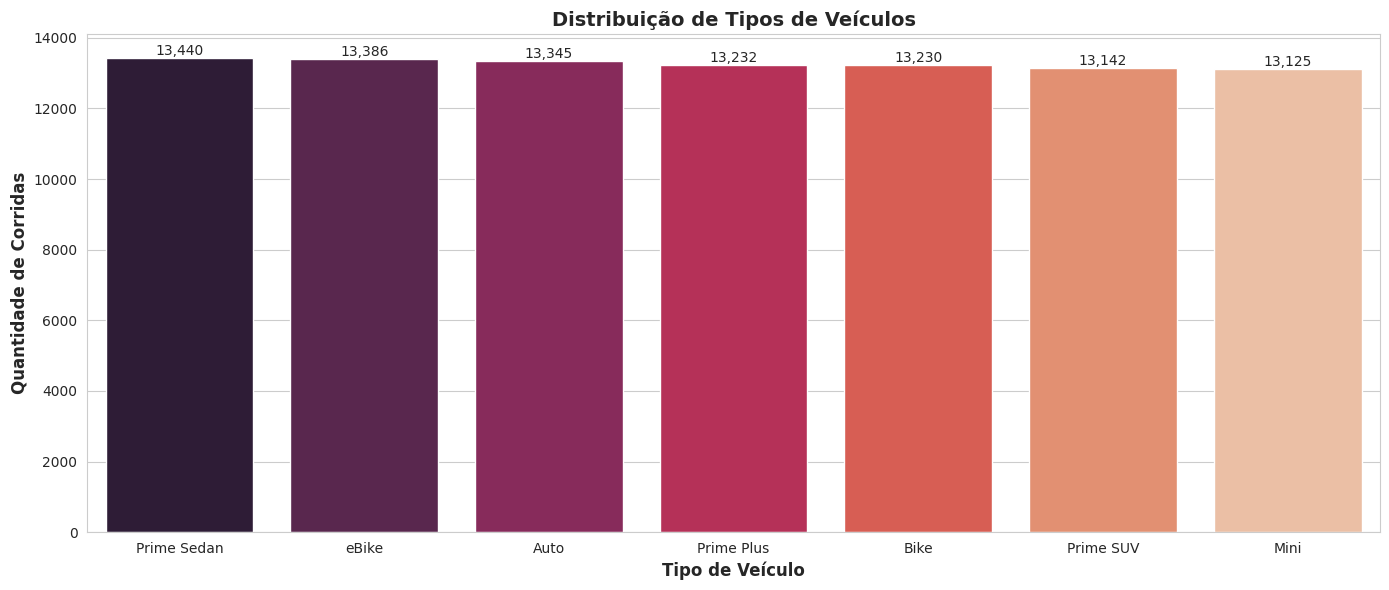

In [12]:
vehicle_types = df_silver.groupBy("Vehicle_Type").count().toPandas()
vehicle_types = vehicle_types.sort_values('count', ascending=False)

fig, ax = plt.subplots(figsize=(14, 6))
sns.barplot(data=vehicle_types, x='Vehicle_Type', y='count', hue='Vehicle_Type', ax=ax, palette='rocket', legend=False)

ax.set_title('Distribuição de Tipos de Veículos', fontsize=14, fontweight='bold')
ax.set_xlabel('Tipo de Veículo', fontsize=12, fontweight='bold')
ax.set_ylabel('Quantidade de Corridas', fontsize=12, fontweight='bold')

for i, v in enumerate(vehicle_types['count']):
    ax.text(i, v, f'{v:,}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

Nova variação de quantidade de viagens por dia por semana.

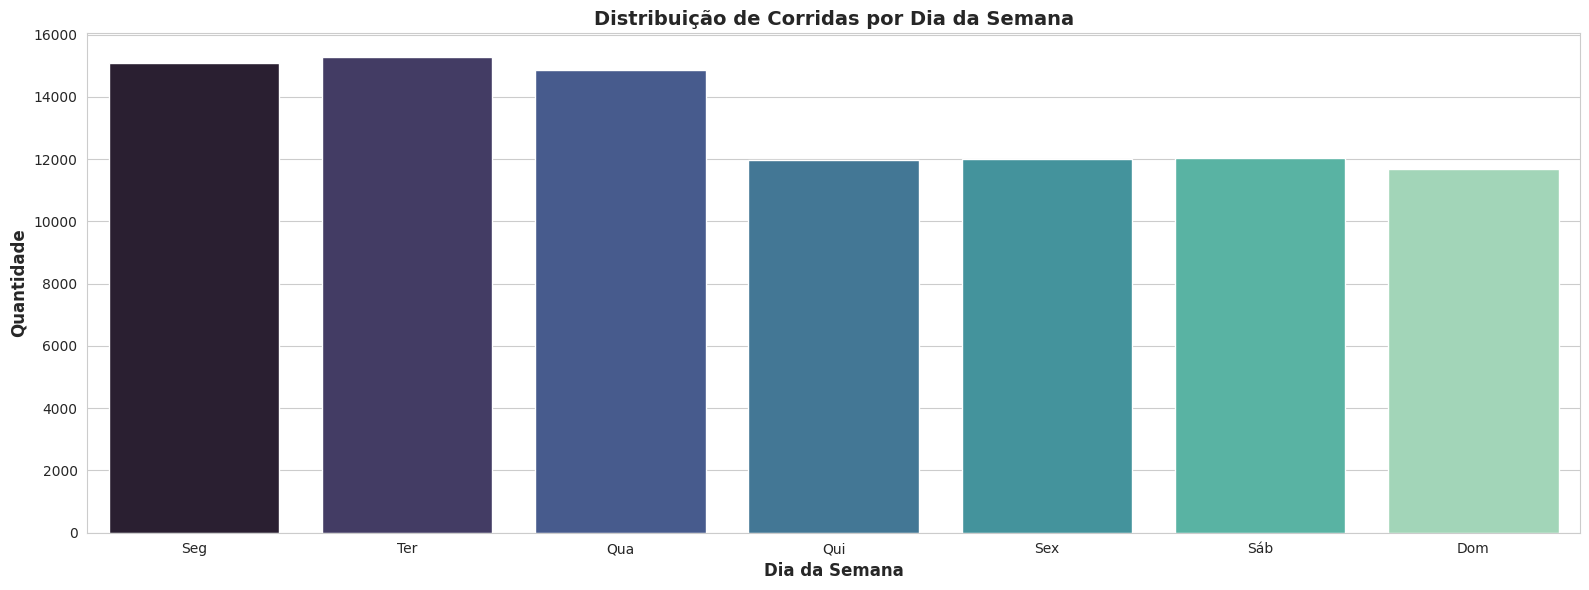

In [13]:
df_temporal = df_silver.select("Date", "Booking_Status").toPandas()
df_temporal['Date'] = pd.to_datetime(df_temporal['Date'])
df_temporal['Month'] = df_temporal['Date'].dt.month
df_temporal['DayOfWeek'] = df_temporal['Date'].dt.dayofweek
df_temporal['Hour'] = df_temporal['Date'].dt.hour

fig, ax = plt.subplots(figsize=(16, 6))

dow_dist = df_temporal.groupby('DayOfWeek').size().reset_index(name='count')
dow_labels = ['Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'Sáb', 'Dom']
dow_dist['DayName'] = dow_dist['DayOfWeek'].apply(lambda x: dow_labels[x])

sns.barplot(data=dow_dist, x='DayName', y='count', hue='DayName', ax=ax, palette='mako')

ax.set_title('Distribuição de Corridas por Dia da Semana', fontsize=14, fontweight='bold')
ax.set_xlabel('Dia da Semana', fontsize=12, fontweight='bold')
ax.set_ylabel('Quantidade', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# 5. Avaliação da Qualidade dos Dados

Realizando a análise da dispersão dos valores numéricos.

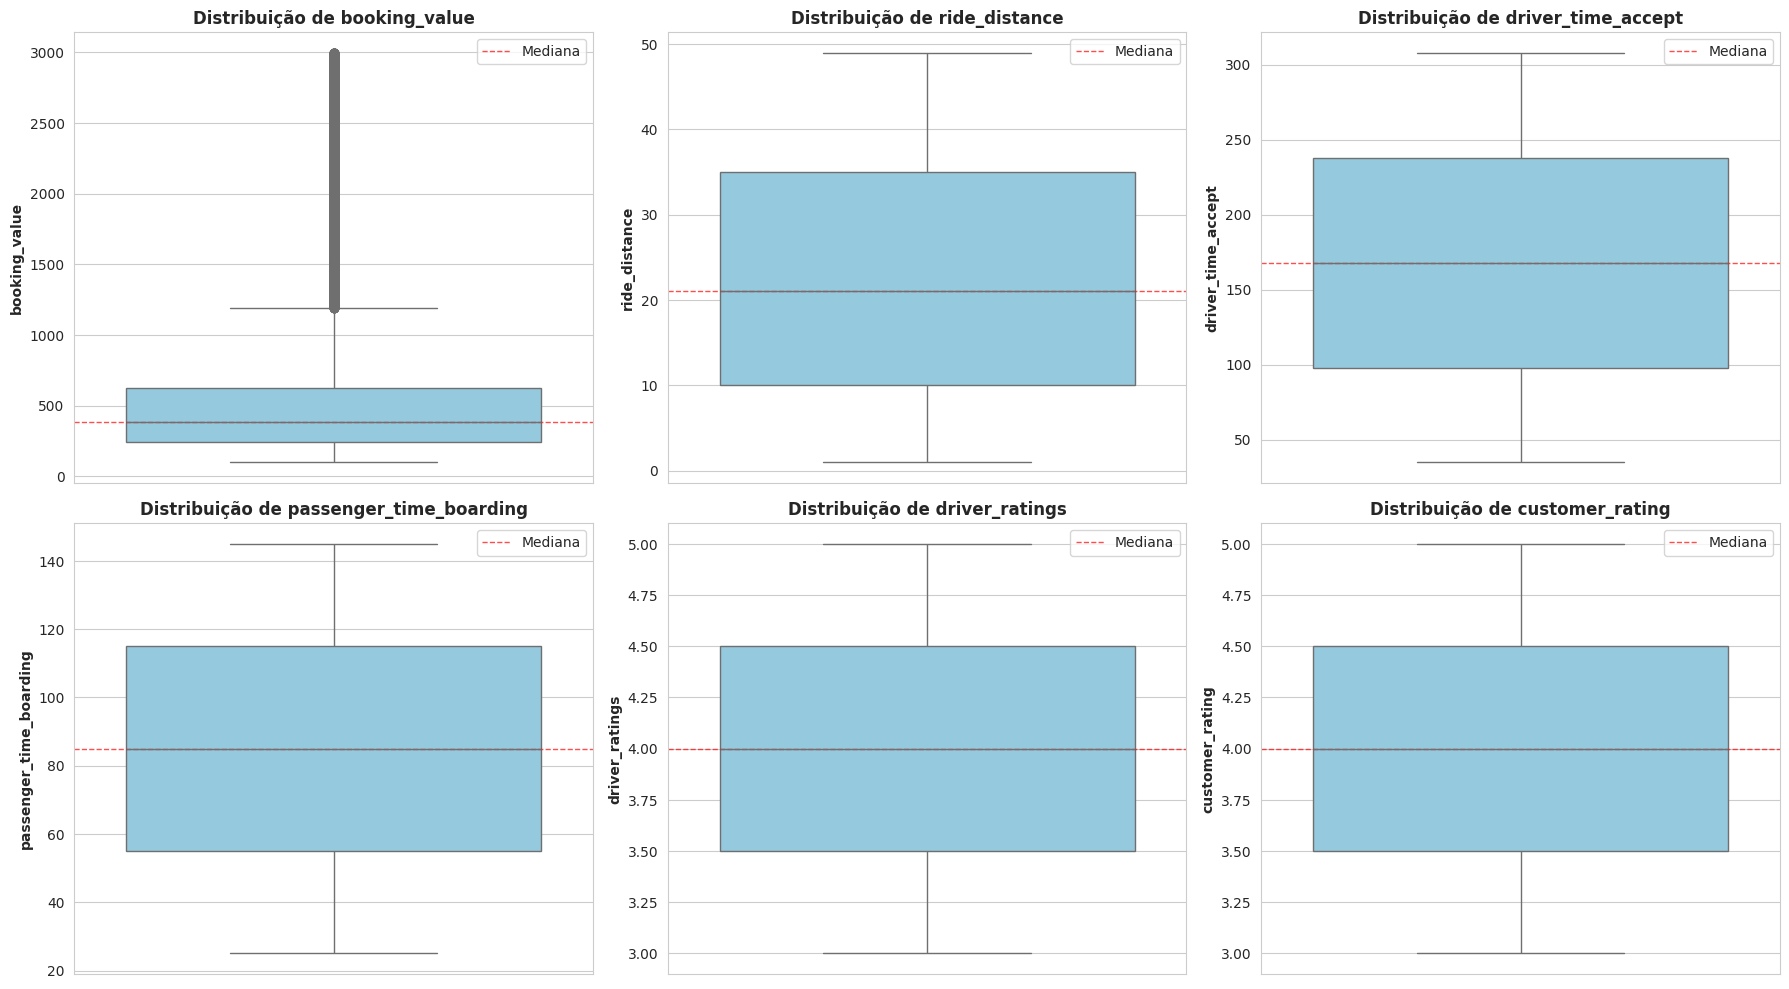

In [15]:
numeric_cols = ['booking_value', 'ride_distance', 'driver_time_accept', 'passenger_time_boarding', 
                'driver_ratings', 'customer_rating']

df_numeric = df_silver.filter(F.col("Booking_Status") == "Success").select(*numeric_cols).toPandas()

# Converter para numérico
for col in numeric_cols:
    df_numeric[col] = pd.to_numeric(df_numeric[col], errors='coerce')

# Boxplots para identificar outliers
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, col in enumerate(numeric_cols):
    sns.boxplot(data=df_numeric, y=col, ax=axes[idx], color='skyblue')
    axes[idx].set_title(f'Distribuição de {col}', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel(col, fontsize=10, fontweight='bold')
    
    # Adicionar estatísticas
    q1 = df_numeric[col].quantile(0.25)
    q3 = df_numeric[col].quantile(0.75)
    median = df_numeric[col].median()
    axes[idx].axhline(median, color='red', linestyle='--', linewidth=1, alpha=0.7, label='Mediana')
    axes[idx].legend()

plt.tight_layout()
plt.show()

# 6. Identificação e Visualização de Outliers

Detecção de Outliers pelo Método de IQR.

                 Coluna    Q1    Q3   IQR  Limite_Inferior  Limite_Superior  Qtd_Outliers  Percentual
          booking_value 242.0 622.0 380.0           -328.0           1192.0          5198    8.126065
          ride_distance  10.0  35.0  25.0            -27.5             72.5             0    0.000000
     driver_time_accept  98.0 238.0 140.0           -112.0            448.0             0    0.000000
passenger_time_boarding  55.0 115.0  60.0            -35.0            205.0             0    0.000000
         driver_ratings   3.5   4.5   1.0              2.0              6.0             0    0.000000
        customer_rating   3.5   4.5   1.0              2.0              6.0             0    0.000000


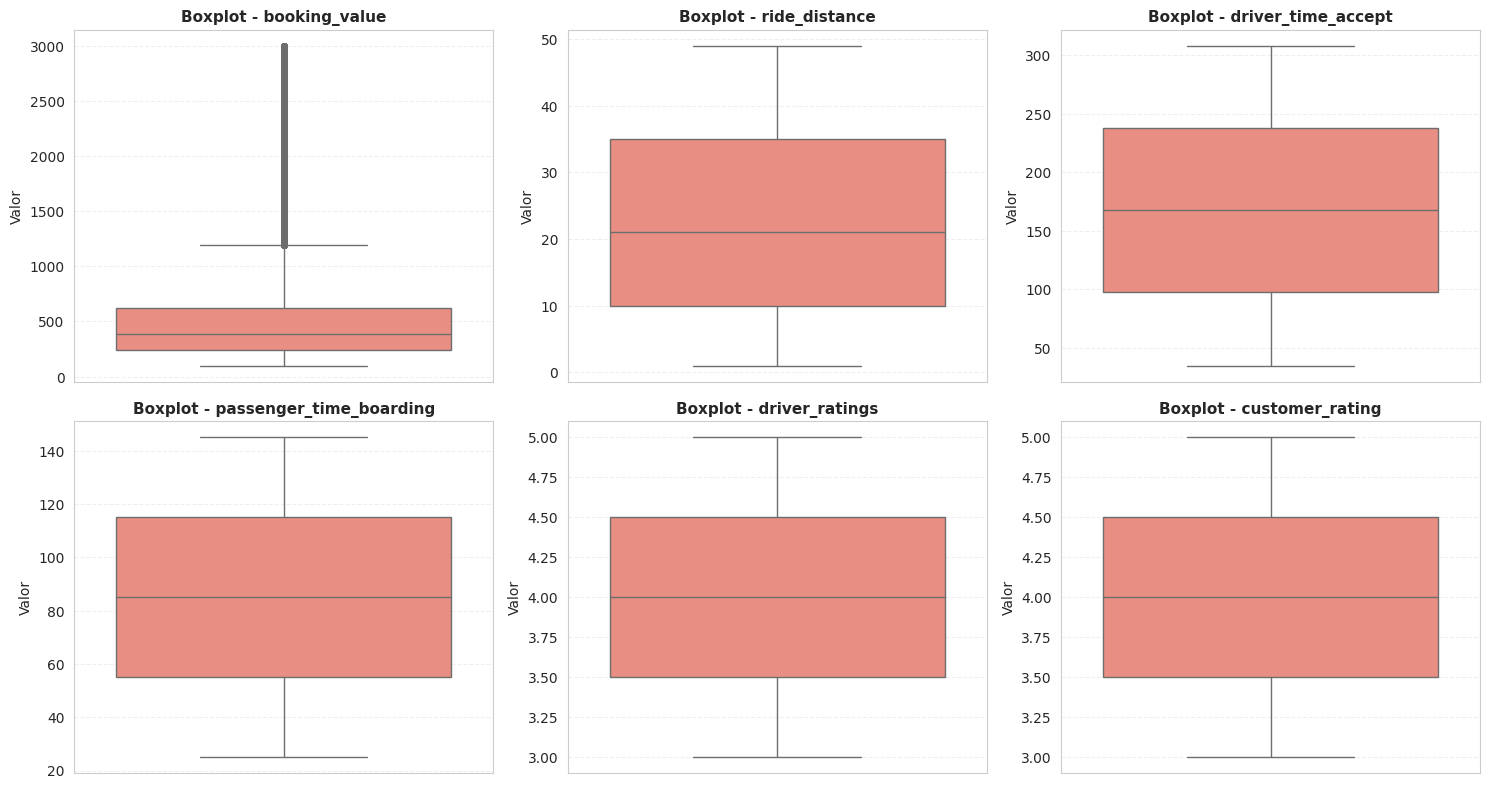

In [17]:
outlier_stats = []
for col in numeric_cols:
    Q1 = df_numeric[col].quantile(0.25)
    Q3 = df_numeric[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df_numeric[(df_numeric[col] < lower_bound) | (df_numeric[col] > upper_bound)]
    outlier_count = len(outliers)
    outlier_pct = (outlier_count / len(df_numeric)) * 100
    
    outlier_stats.append({
        'Coluna': col,
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR,
        'Limite_Inferior': lower_bound,
        'Limite_Superior': upper_bound,
        'Qtd_Outliers': outlier_count,
        'Percentual': outlier_pct
    })

outlier_df = pd.DataFrame(outlier_stats)
print(outlier_df.to_string(index=False))

num_cols = len(numeric_cols)
cols = 3
rows = (num_cols + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.boxplot(
        y=df_numeric[col],
        ax=axes[i],
        color='salmon',
        showfliers=True,
        flierprops=dict(marker='o', markersize=4, alpha=0.5)
    )
    
    axes[i].set_title(f'Boxplot - {col}', fontsize=11, fontweight='bold')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Valor')
    axes[i].grid(axis='y', alpha=0.3, linestyle='--')


plt.tight_layout()
plt.show()

# 7. Detecção de Anomalias

Matriz de correlação para visualização dos dados numéricos.

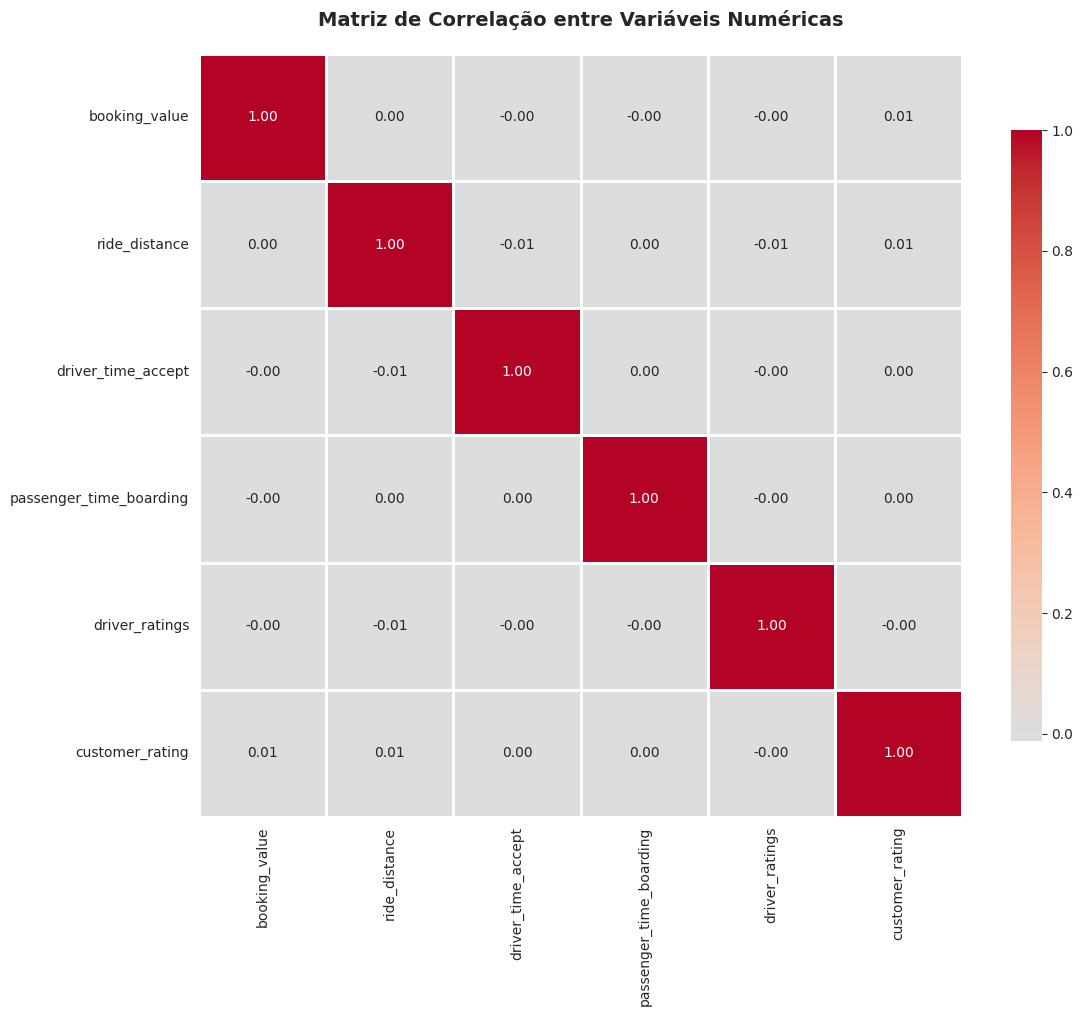

In [18]:
correlation_matrix = df_numeric.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8}, fmt='.2f')
plt.title('Matriz de Correlação entre Variáveis Numéricas', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

Visualização da distruibuição dos tipos de pagamentos usados.

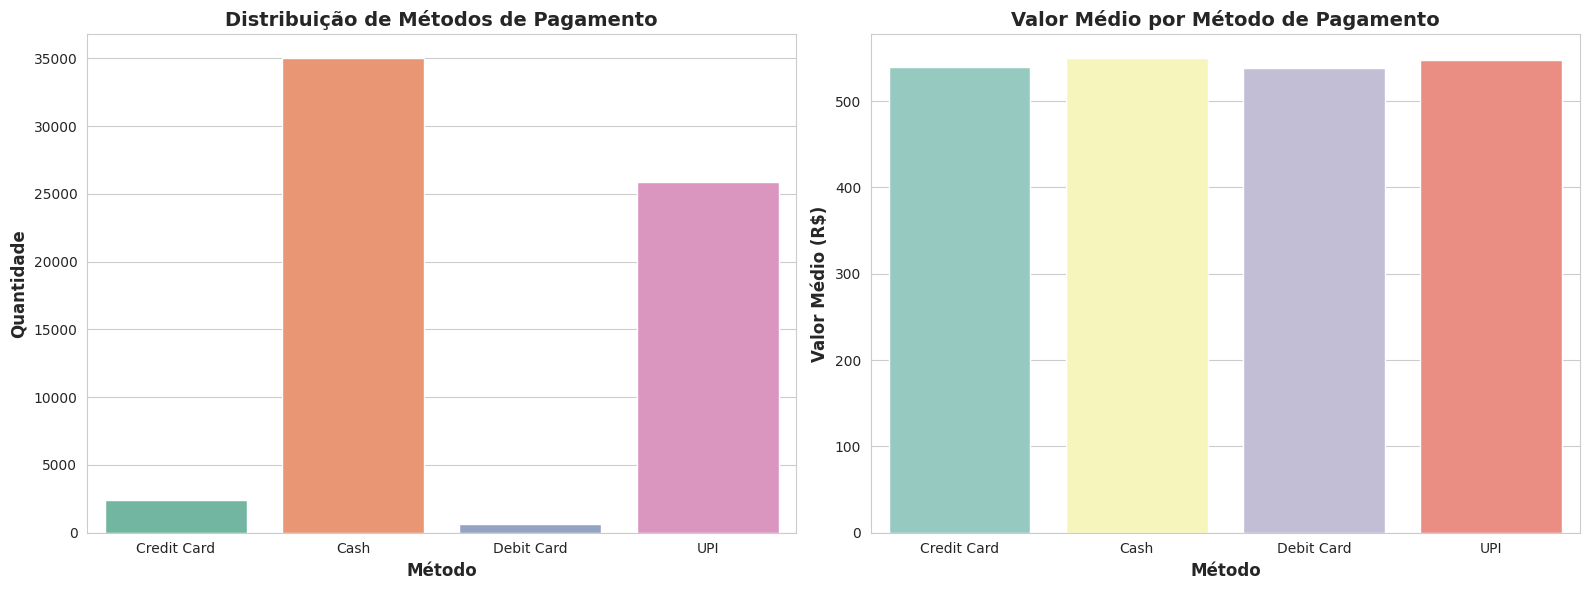

In [19]:
# Análise de métodos de pagamento
payment_analysis = df_silver.filter(F.col("Booking_Status") == "Success").groupBy("Payment_Method").agg(
    F.count("*").alias("Quantidade"),
    F.avg("Booking_Value").alias("Valor_Medio")
).toPandas()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

sns.barplot(data=payment_analysis, x='Payment_Method', y='Quantidade', hue='Payment_Method', ax=ax1, palette='Set2', legend=False)
ax1.set_title('Distribuição de Métodos de Pagamento', fontsize=14, fontweight='bold')
ax1.set_xlabel('Método', fontsize=12, fontweight='bold')
ax1.set_ylabel('Quantidade', fontsize=12, fontweight='bold')

sns.barplot(data=payment_analysis, x='Payment_Method', y='Valor_Medio', hue='Payment_Method', ax=ax2, palette='Set3', legend=False)
ax2.set_title('Valor Médio por Método de Pagamento', fontsize=14, fontweight='bold')
ax2.set_xlabel('Método', fontsize=12, fontweight='bold')
ax2.set_ylabel('Valor Médio (R$)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

Análise de rotas mais frequentes

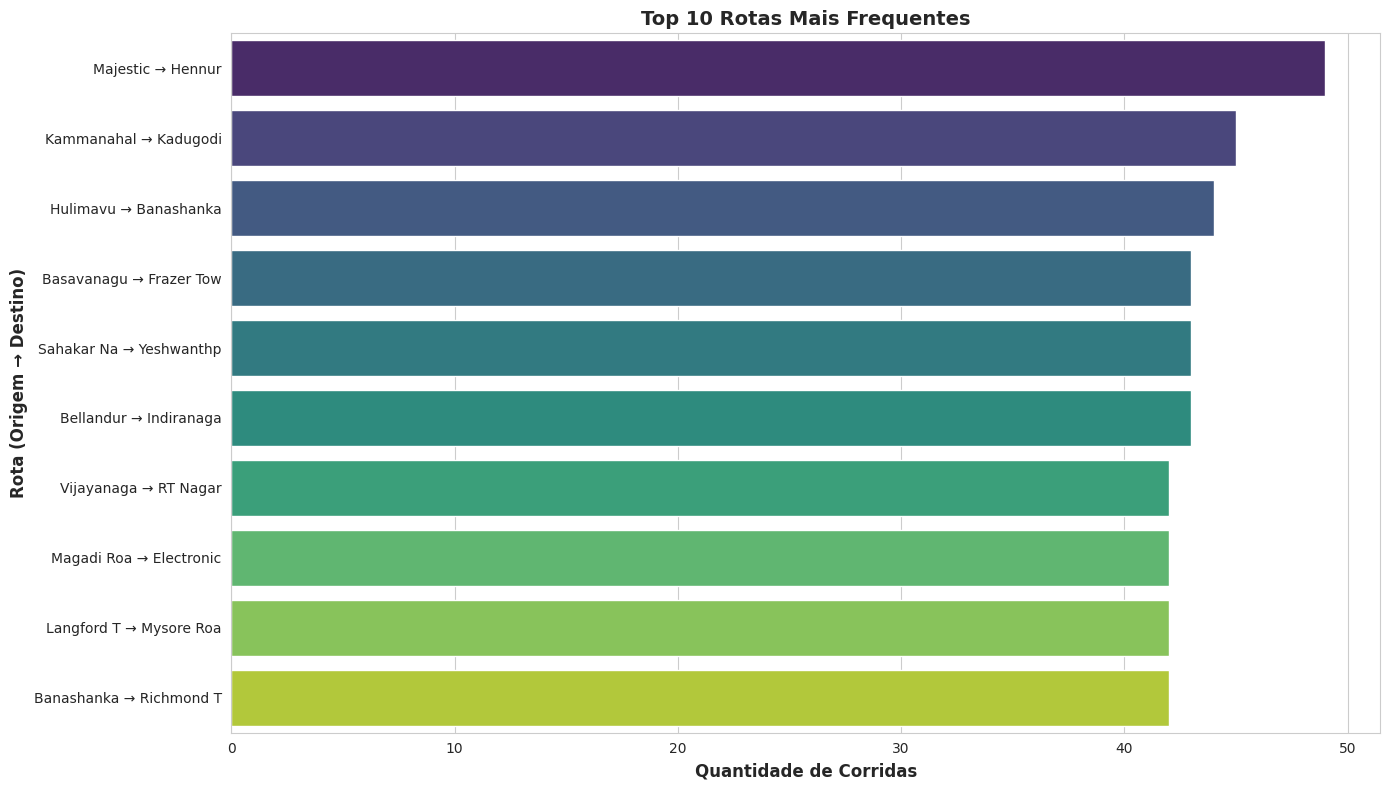

In [21]:
route_analysis = df_silver.filter(F.col("Booking_Status") == "Success").groupBy("Pickup_Location", "Drop_Location").agg(
    F.count("*").alias("Quantidade")
).orderBy(F.desc("Quantidade")).limit(10).toPandas()

plt.figure(figsize=(14, 8))
route_labels = [f"{row['Pickup_Location'][:10]} → {row['Drop_Location'][:10]}" for _, row in route_analysis.iterrows()]

sns.barplot(x='Quantidade', y=route_labels, data=route_analysis, palette='viridis', hue=route_labels)
plt.title('Top 10 Rotas Mais Frequentes', fontsize=14, fontweight='bold')
plt.xlabel('Quantidade de Corridas', fontsize=12, fontweight='bold')
plt.ylabel('Rota (Origem → Destino)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()